# Group Project (MGTA - 415)

In [2]:
import numpy as np
import pandas as pd
import gzip
import json
import os
import itertools
import string
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import word2vec
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, make_scorer, accuracy_score, classification_report, roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.model_selection import train_test_split
import time
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

## Reading and converting data into features with Explaratory data analysis

*Objective of Exploratory Analysis is to remove data rows that have NAs, remove any outliers and clean data for modelling purposes.*

In [3]:
path = "renttherunway_final_data.json.gz"
review_data = []
with gzip.open(path,'rb') as file:
    for line in file:
        row_data = json.loads(line)
        review_data.append(row_data)

In [4]:
data = pd.DataFrame(review_data)
data.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


In [5]:
# Check the datatypes
data.dtypes

fit               object
user_id           object
bust size         object
item_id           object
weight            object
rating            object
rented for        object
review_text       object
body type         object
review_summary    object
category          object
height            object
size               int64
age               object
review_date       object
dtype: object

In [6]:
# check rows with na value
data.isna().sum()

fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64

In [7]:
# dropping all rows missing values for any of the features

data = data.dropna()
data = data.reset_index(drop = True)
data.shape

(146381, 15)

In [8]:
# Change the data types
data['fit'] = data['fit'].astype('category')
data['user_id'] = data['user_id'].astype(np.int64)
data['bust size'] = data['bust size'].astype(str)
data['item_id'] = data['item_id'].astype(np.int64)
data['weight'] = data['weight'].astype(str)
data['rating'] = data['rating'].astype(np.float64)
data['rented for'] = data['rented for'].astype('category')
data['review_text'] = data['review_text'].astype(str)
data['body type'] = data['body type'].astype('category')
data['review_summary'] = data['review_summary'].astype(str)
data['category'] = data['category'].astype('category')
data['height'] = data['height'].astype(str)
data['size'] = data['size'].astype(np.int32)
data['age'] = data['age'].astype(np.float64)
data['review_date'] = data['review_date'].astype(str)

### Check the distribution of the data

##### Bust size has two fields - one is the numerical value and the other is an alphabet or a combination of alphabets and special characters. Hence we are breaking this in to two fields (numerical and categorical)

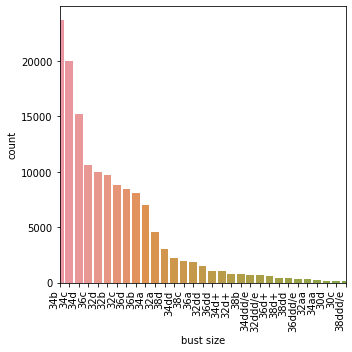

Number of Unique Categories for Bust Size: 101


In [9]:
# Distribution plot for Bust size
plt.figure(figsize=(5,5))
ax = sns.countplot(x="bust size", data=data, order = data['bust size'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_xlim(left = 0, right = 30)
plt.tight_layout()
plt.show()

# Total categories
print('Number of Unique Categories for Bust Size:', len(set(data['bust size'])))

In [10]:
# Convert bust size into 2 variables
data['bust_inch'] = [d[:2] for d in data['bust size']]
data['bust_alphabet'] = [d[2:].strip() for d in data['bust size']]
data['bust_alphabet'] = data['bust_alphabet'].astype('category')

#### Weight - the numerical value is extracted and only that value is used.

In [11]:
# converting weights into numeric
data['weight'] = [d.replace('lbs', '') for d in data['weight']]
data['weight'] = data['weight'].astype(np.float64)

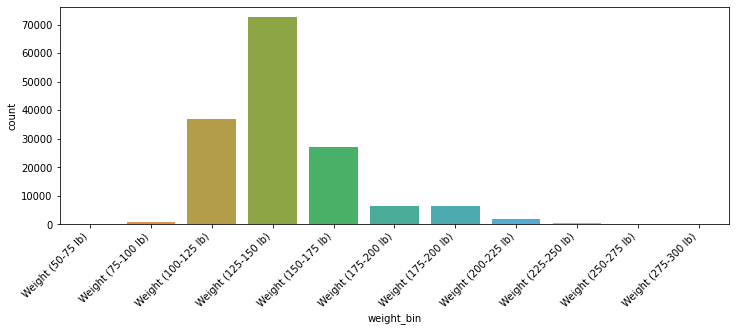

Weight (50-75 lb)          7
Weight (275-300 lb)       29
Weight (250-275 lb)      205
Weight (225-250 lb)      476
Weight (75-100 lb)       647
Weight (200-225 lb)     1892
Weight (175-200 lb)     6373
Weight (150-175 lb)    27172
Weight (100-125 lb)    37021
Weight (125-150 lb)    72559
Name: weight_bin, dtype: int64

In [12]:
def binning_operation(value):
    if value >= 50 and value < 75:
        column_value = 'Weight (50-75 lb)'
    elif value >= 75 and value < 100:
        column_value = 'Weight (75-100 lb)'
    elif value >= 100 and value < 125:
        column_value = 'Weight (100-125 lb)'
    elif value >= 125 and value < 150:
        column_value = 'Weight (125-150 lb)'
    elif value >= 150 and value < 175:
        column_value = 'Weight (150-175 lb)'
    elif value >= 175 and value < 200:
        column_value = 'Weight (175-200 lb)'
    elif value >= 200 and value < 225:
        column_value = 'Weight (200-225 lb)'
    elif value >= 225 and value < 250:
        column_value = 'Weight (225-250 lb)'
    elif value >= 250 and value < 275:
        column_value = 'Weight (250-275 lb)'
    elif value >= 275 and value <= 300:
        column_value = 'Weight (275-300 lb)'
    
    return column_value


data['weight_bin'] = data['weight'].apply(binning_operation)
order_list = ['Weight (50-75 lb)', 'Weight (75-100 lb)', 'Weight (100-125 lb)', 'Weight (125-150 lb)',
              'Weight (150-175 lb)', 'Weight (175-200 lb)', 'Weight (175-200 lb)', 'Weight (200-225 lb)',
              'Weight (225-250 lb)', 'Weight (250-275 lb)', 'Weight (275-300 lb)']

# Plot the distribution
plt.figure(figsize=(12,4))
ax = sns.countplot(x="weight_bin", data=data, order = order_list)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

# Print the count
data['weight_bin'].value_counts(ascending = True)

#### Rating - this is our response variable, we treat it as numerical variable

10.0    94291
8.0     40761
6.0      8341
4.0      2205
2.0       783
Name: rating, dtype: int64




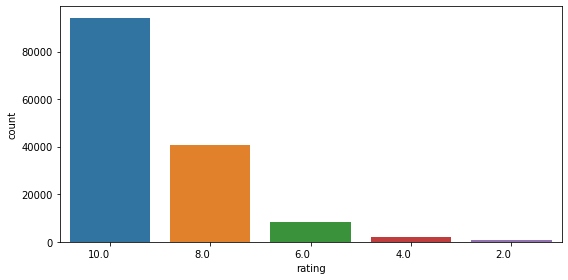

In [13]:
## ratings
print(data['rating'].value_counts(dropna=False))
print("")
print("")
plt.figure(figsize=(8,4))
ax = sns.countplot(x="rating", data=data, order = data['rating'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.tight_layout()
plt.show()

#### Rented for is a categorical variable. Here we remove the occasion 'party: cocktail' as it only has one value

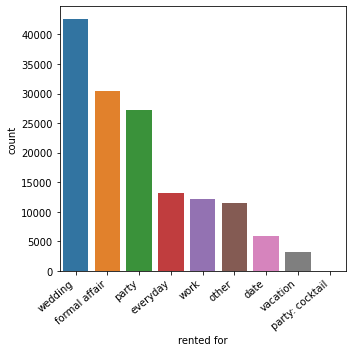

wedding            42622
formal affair      30496
party              27198
everyday           13263
work               12124
other              11510
date                5929
vacation            3238
party: cocktail        1
Name: rented for, dtype: int64

In [14]:
# Plot Distribution for 'rented for'

plt.figure(figsize=(5,5))
ax = sns.countplot(x="rented for", data=data, order = data['rented for'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

# Count Table
data['rented for'].value_counts()

In [15]:
# removing one the rented for entry because it is an outlier
data = data[data['rented for'] != 'party: cocktail']

#### body type - categorical variable

hourglass            43982
athletic             37518
petite               19357
pear                 18051
straight & narrow    12866
full bust            10797
apple                 3809
Name: body type, dtype: int64


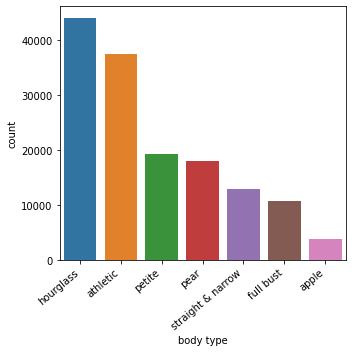

In [16]:
print(data['body type'].value_counts(dropna=False))
plt.figure(figsize=(5,5))
ax = sns.countplot(x="body type", data=data, order = data['body type'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#ax.set_xlim(left = 0, right = 50)
plt.tight_layout()
plt.show()

#### category - categorical variable

dress           70473
gown            33278
sheath          14691
shift            4039
jumpsuit         4019
                ...  
sweatershirt        3
buttondown          1
crewneck            1
sweatpants          1
overcoat            1
Name: category, Length: 68, dtype: int64


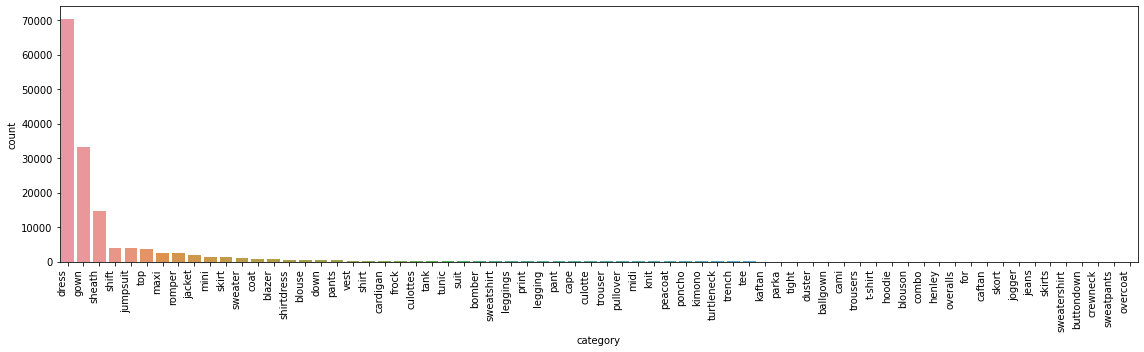

In [17]:
print(data['category'].value_counts(dropna=False))
plt.figure(figsize=(16,5))
ax = sns.countplot(x="category", data=data, order = data['category'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
#ax.set_xlim(left = 0, right = 50)
plt.tight_layout()
plt.show()

#### Height - this variable is converted in to inches

<Figure size 1440x1440 with 0 Axes>

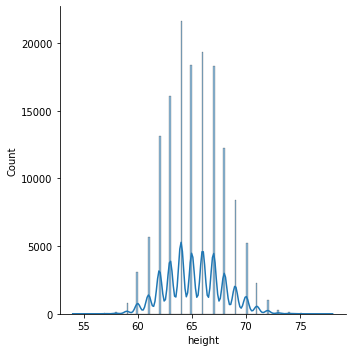

In [18]:
# converting height into numeric
data['height'] = [int(d.split('\' ')[0])*12 + int(d.split('\' ')[1].split("\"")[0]) for d in data['height']]

# Plot distribution for height
plt.figure(figsize=(20,20))
sns.displot(data['height'], kde=True)

#### Size - this is a numeric variable

<Figure size 1440x1440 with 0 Axes>

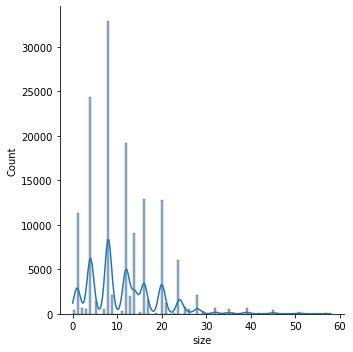

In [19]:
# Plot distribution for size
plt.figure(figsize=(20,20))
sns.displot(data['size'], kde=True)

#### Age - this is a numeric variable (only ages greater than zero and less than equal to 80 are considered)

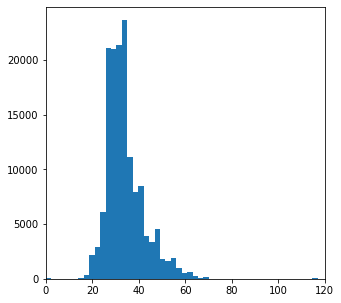

In [20]:
# Plot Distribution for Age

plt.figure(figsize = (5,5))
plt.hist(data['age'], bins = 50)
plt.xlim(0, 120)
plt.show()

In [21]:
# restricting the age to more than 0 and less than 80
data = data[np.logical_and(data.age > 0, data.age <= 80)]

#### Additional data fields included are as below

In [22]:
# converting time into unix format
data['review_date_converted'] = [time.mktime(time.strptime(d, '%B %d, %Y')) for d in data['review_date']]

# combining text fields review summary and review text
data["text"] = data['review_summary'] + ' ' + data['review_text']

# getting the length of review
data["text_length"] = [len(d) for d in data["text"]]

In [23]:
data.shape

(146289, 21)

In [24]:
data.columns

Index(['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'size', 'age', 'review_date', 'bust_inch', 'bust_alphabet',
       'weight_bin', 'review_date_converted', 'text', 'text_length'],
      dtype='object')

In [25]:
# A function used to build a vocabulary based on descending word frequencies 
def build_vocab(sentences):
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv


# A function used to learn word embeddings through Word2vec module
def get_embeddings(inp_data, vocabulary_inv, size_features=100, mode='skipgram', min_word_count=2, context=5, model='word2vec'):
    model_name = "embedding"
    model_name = os.path.join(model_name)

    if model == 'word2vec':
        num_workers = 15  # Number of threads to run in parallel
        downsampling = 1e-3  # Downsample setting for frequent words
        print('Training Word2Vec model...')
        # use inp_data and vocabulary_inv to reconstruct sentences
        sentences = [[vocabulary_inv[w] for w in s] for s in inp_data]
        if mode == 'skipgram':
            sg = 1
            print('Model: skip-gram')
        elif mode == 'cbow':
            sg = 0
            print('Model: CBOW')
        embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                            sg=sg,
                                            vector_size=size_features,
                                            min_count=min_word_count,
                                            window=context,
                                            sample=downsampling)
        print("Saving Word2Vec model {}".format(model_name))
        embedding_weights = np.zeros((len(vocabulary_inv), size_features))
        for i in range(len(vocabulary_inv)):
            word = vocabulary_inv[i]
            if word in embedding_model.wv:
                embedding_weights[i] = embedding_model.wv[word]
            else:
                embedding_weights[i] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
        return embedding_weights
    elif model == 'glove':
        size_features = 300
        glove_file = "glove.6B.300d.txt"
        tmp_file = get_tmpfile("test_word2vec.txt")

        _ = glove2word2vec(glove_file, tmp_file)

        glv_model = KeyedVectors.load_word2vec_format(tmp_file)
        print('Training GloVe model...')
        embedding_model = glv_model
        print("Saving GloVe model {}".format(model_name))
        embedding_weights = np.zeros((len(vocabulary_inv), size_features))
        for i in range(len(vocabulary_inv)):
            word = vocabulary_inv[i]
            if word in embedding_model:
                embedding_weights[i] = embedding_model[word]
            else:
                embedding_weights[i] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
        return embedding_weights
    return -1

def preprocess_df(df):
    # get English stopwords
    en = spacy.load('en_core_web_sm')
    sw_spacy = en.Defaults.stop_words
    stop_words = set(sw_spacy)
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row["text"].lower()
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word for word in words_list if word not in stop_words and len(word) != 1] # also skip space from above translation
        preprocessed_sentences.append(" ".join(filtered_words))
    df["text"] = preprocessed_sentences
    return df

#### Data was further cleaned up post embedding to reomve entries with the 'text' field length to be greater than two.

In [25]:
data = preprocess_df(data)

# removing empty review columns
data = data[data['text'].apply(lambda x: len(x) > 2)]

### Word2Vec Model - min_word_count = 2, context = 10, mode = skipgram

### Logistic regression with max_iteration = 100000000, C = 0.001

In [26]:
data['rating'] = data['rating'].astype('int')

X = data[['fit', 'weight', 'rented for', 'body type', 'category', 
            'height', 'size', 'age', 'text', 'bust_inch', 
            'bust_alphabet', 'review_date_converted', 'text_length']]
y = data['rating'].values


X = pd.get_dummies(X, columns = ['fit','rented for','body type', 'bust_alphabet', 'category'], drop_first=True)
#y = pd.get_dummies(y, columns=['rating'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# tokenization 
tagged_data = [word_tokenize(_d) for i, _d in enumerate(X_train["text"])]

# build vocabulary from tokenized data
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_data)

# use the above mapping to create input data
inp_data = [[vocabulary[word] for word in text] for text in tagged_data]

# get embedding vector
embedding_weights = get_embeddings(inp_data, vocabulary_inv, mode='skipgram', min_word_count=2, context=10)
tagged_train_data = [word_tokenize(_d) for i, _d in enumerate(X_train["text"])]
tagged_test_data = [word_tokenize(_d) for i, _d in enumerate(X_test["text"])]

Training Word2Vec model...
Model: skip-gram
Saving Word2Vec model embedding


In [29]:
# Removing text field from the columns to get other features
cols_list = X.columns.tolist()
cols_list.pop(4)

def feature(d):
    feat = []
    for col in cols_list:
        feat.append(d[col])
    return feat

In [30]:
train_vec = []
for doc in tagged_train_data:
    vec = 0
    for w in doc:
        vec += embedding_weights[vocabulary[w]]
    vec = vec / len(doc)
    train_vec.append(vec)
train_vec = [v.tolist() for v in train_vec]
train_data_features = [feature(d) for _, d in X_train.iterrows()]
train_data_final = [train_data_features[s] + train_vec[s] for s in range(len(train_data_features))]


test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights[vocabulary[w]]
            length += 1
        except:
            vec = np.zeros((100, ), dtype=np.float64)
            continue
    if length != 0:
        vec = vec / length
    test_vec.append(vec)
test_vec = [v1.tolist() for v1 in test_vec]
test_data_features = [feature(d) for _, d in X_test.iterrows()]
test_data_final = [test_data_features[s] + test_vec[s] for s in range(len(test_data_features))]

In [ ]:
# COMMENTED ON PURPOSE, BEST C = 0.001

#param_grid = [
#    {
#        'C' : [0.001, 0.01, 0.1, 1, 10, 100]
#    }
#]
#clf = GridSearchCV(LogisticRegression(max_iter=100000000), param_grid = param_grid, cv = 5, n_jobs=-1, scoring='accuracy', verbose=10).fit(train_data_final, y_train.values.ravel())
#print(clf.best_params_, clf.best_score_)

In [31]:
clf = LinearRegression().fit(train_data_final, y_train)
y_pred = clf.predict(test_data_final)
print(mean_squared_error(y_test, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


1.4431975931194703


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


### Word2Vec Model - min_word_count = 2, context = 5, mode = cbow

### Logistic regression with max_iteration = 100000000, C = 0.001

In [30]:
data['rating'] = data['rating'].astype('int')

X = data[['fit', 'weight', 'rented for', 'body type', 'category', 
            'height', 'size', 'age', 'text', 'bust_inch', 
            'bust_alphabet', 'review_date_converted', 'text_length']]
y = data['rating'].values

X = pd.get_dummies(X, columns = ['fit','rented for','body type', 'bust_alphabet', 'category'], drop_first=True)
#y = pd.get_dummies(y, columns=['rating'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# tokenization 
tagged_data = [word_tokenize(_d) for i, _d in enumerate(X_train["text"])]

# build vocabulary from tokenized data
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_data)

# use the above mapping to create input data
inp_data = [[vocabulary[word] for word in text] for text in tagged_data]



Training Word2Vec model...
Model: CBOW
Saving Word2Vec model embedding


In [32]:
# get embedding vector
embedding_weights = get_embeddings(inp_data, vocabulary_inv, min_word_count = 2, context = 5, mode='cbow')
tagged_train_data = [word_tokenize(_d) for i, _d in enumerate(X_train["text"])]
tagged_test_data = [word_tokenize(_d) for i, _d in enumerate(X_test["text"])]

Training Word2Vec model...
Model: CBOW
Saving Word2Vec model embedding


In [33]:
# Removing text field from the columns to get other features
cols_list = X.columns.tolist()
cols_list.pop(4)

def feature(d):
    feat = []
    for col in cols_list:
        feat.append(d[col])
    return feat

In [34]:
train_vec = []
for doc in tagged_train_data:
    vec = 0
    for w in doc:
        vec += embedding_weights[vocabulary[w]]
    vec = vec / len(doc)
    train_vec.append(vec)


train_vec = [v.tolist() for v in train_vec]
train_data_features = [feature(d) for _, d in X_train.iterrows()]
train_data_final = [train_data_features[s] + train_vec[s] for s in range(len(train_data_features))]

test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights[vocabulary[w]]
            length += 1
        except:
            vec = np.zeros((100, ), dtype=np.float64)
            continue
    if length != 0:
        vec = vec / length
    test_vec.append(vec)

test_vec = [v1.tolist() for v1 in test_vec]
test_data_features = [feature(d) for _, d in X_test.iterrows()]
test_data_final = [test_data_features[s] + test_vec[s] for s in range(len(test_data_features))]

In [35]:
clf = LinearRegression().fit(train_data_final, y_train)
y_pred = clf.predict(test_data_final)
print(mean_squared_error(y_test, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


1.5036389325299662


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


### GloVe

In [38]:
def get_embeddings_g(inp_data, vocabulary_inv):
    glove_file = 'glove.6B.300d.txt'
    tmp_file = get_tmpfile("test_word2vec.txt")
    _ = glove2word2vec(glove_file, tmp_file)
    embedding_model = KeyedVectors.load_word2vec_format(tmp_file)
    embedding_weights = np.zeros((len(vocabulary_inv), 300))
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model:
            embedding_weights[i] = embedding_model[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
    return embedding_weights

In [39]:
embedding_weights = get_embeddings_g(inp_data, vocabulary_inv)

<ipython-input-38-f2fc37ce7895>:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


In [40]:
train_vec = []
for doc in tagged_train_data:
    vec = 0
    for w in doc:
        vec += embedding_weights[vocabulary[w]]
    vec = vec / len(doc)
    train_vec.append(vec)
train_vec = [v.tolist() for v in train_vec]
train_data_features = [feature(d) for _, d in X_train.iterrows()]
train_data_final = [train_data_features[s] + train_vec[s] for s in range(len(train_data_features))]

test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights[vocabulary[w]]
            length += 1
        except:
            vec = np.zeros((300, ), dtype=np.float64) # 300 dims
            continue
    if length != 0:
        vec = vec / length
    test_vec.append(vec)
test_vec = [v1.tolist() for v1 in test_vec]
test_data_features = [feature(d) for _, d in X_test.iterrows()]
test_data_final = [test_data_features[s] + test_vec[s] for s in range(len(test_data_features))]

In [41]:
clf = LinearRegression().fit(train_data_final, y_train)
y_pred = clf.predict(test_data_final)
print(mean_squared_error(y_test, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


1.4924038083333493
